# plaq-u-net: multi-patch consensus U-Net for automated detection and segmentation of the carotid arteries on black blood MRI sequences

E. Lavrova, 2022  
  
This is a code supporting the corresponding paper.

Packages import:

In [1]:
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import pydicom
import random
import matplotlib.pyplot as plt
import glob
import matplotlib.patches as patches

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage import morphology
from skimage.filters import threshold_otsu, threshold_local

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from sklearn.model_selection import train_test_split

import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import random
import pandas as pd

import albumentations as A

import SimpleITK as sitk

plt.style.use("ggplot")

Using TensorFlow backend.
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


GPU assignment:

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '1,2'                        
import tensorflow as tf
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

W0623 13:25:34.920538 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0623 13:25:34.922541 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0623 13:25:34.924540 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0623 13:25:39.155420 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:1']

## 1. Data load

Getting image/contour names:

In [3]:
images = glob.glob('../data/*/T1W_*.dcm')
contours = glob.glob('../data/*/MASSExport/*.dcm')

Number of image/contour files:

In [4]:
len(images), len(contours)

(2806, 2821)

Getting patients with contours presented:

In [5]:
sub_names_list = []
for image in images:
    sub_name = image.split(os.sep)[1].split('_')[0]
    con_names = glob.glob(os.path.join(os.path.split(image)[0],'MASSExport')+os.sep+'*'+ image.split(os.sep)[2][-10:-4]+'*.dcm')
    if len(con_names)>0:
        sub_names_list.append(sub_name)
        
sub_names = np.unique(sub_names_list)

Splitting subs into centers:

In [6]:
sub_names_amc = []
sub_names_mumc = []
sub_names_umcu = []
sub_names_emc = []

for sub_name in sub_names:
    if 'AMC' in sub_name:
        sub_names_amc.append(sub_name)
    if 'MUMC' in sub_name:
        sub_names_mumc.append(sub_name)
    if 'UMCU' in sub_name:
        sub_names_umcu.append(sub_name)
    if 'EMC' in sub_name:
        sub_names_emc.append(sub_name)
        
print (len(sub_names_amc), len(sub_names_mumc), len(sub_names_umcu), len(sub_names_emc))

13 115 25 34


Data split for training, validation, and testing stratified per center:

In [7]:
sub_names_amc_train, sub_names_amc_valid_test = train_test_split(sub_names_amc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_amc_valid, sub_names_amc_test = train_test_split(sub_names_amc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_mumc_train, sub_names_mumc_valid_test = train_test_split(sub_names_mumc, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_mumc_valid, sub_names_mumc_test = train_test_split(sub_names_mumc_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_umcu_train, sub_names_umcu_valid_test = train_test_split(sub_names_umcu, test_size=0.3, 
                                                                 random_state=2022, shuffle=True)
sub_names_umcu_valid, sub_names_umcu_test = train_test_split(sub_names_umcu_valid_test, test_size=0.5, 
                                                           random_state=2022, shuffle=True)

sub_names_train = sub_names_amc_train + sub_names_mumc_train + sub_names_umcu_train
sub_names_valid = sub_names_amc_valid + sub_names_mumc_valid + sub_names_umcu_valid
sub_names_test = sub_names_amc_test + sub_names_mumc_test + sub_names_umcu_test

print (len(sub_names_amc_train), len(sub_names_mumc_train), len(sub_names_umcu_train))
print (len(sub_names_amc_valid), len(sub_names_mumc_valid), len(sub_names_umcu_valid))
print (len(sub_names_amc_test), len(sub_names_mumc_test), len(sub_names_umcu_test))
print (len(sub_names_emc))

9 80 17
2 17 4
2 18 4
34


Number of patients in training, validation, and testing subsets per center:

|DS | Total  | Train    | Valid   | Test   | Ext test |
|---:|:-------------|:-----------|:------|:------|:-----|
| AMC | 13  | 9 | 2   | 2     |0|
| MUMC | 115  | 80    | 17   | 18     |0|
| UMCU | 25  | 17    | 4   | 4     |0|  
| EMC | 34|0|0|0|34|
| Total | 187  | 106    | 23   | 24     |34|

Getting .dcm files for every subset:

In [8]:
img_names_train = []
img_names_valid = []
img_names_test = []

for sub_name_train in sub_names_train:
    img_names_train.extend(glob.glob('../data/'+sub_name_train+'*/T1W_*.dcm'))

for sub_name_valid in sub_names_valid:
    img_names_valid.extend(glob.glob('../data/'+sub_name_valid+'*/T1W_*.dcm'))
    
for sub_name_test in sub_names_test:
    img_names_test.extend(glob.glob('../data/'+sub_name_test+'*/T1W_*.dcm'))
    
print (len(img_names_train), len(img_names_valid), len(img_names_test))

1589 345 360


In [9]:
img_names_emc = []

for sub_name_emc in sub_names_emc:
    img_names_emc.extend(glob.glob('../data/'+sub_name_emc+'*/T1W_*.dcm'))
    
len(img_names_emc)

512

Training data aggregation:

In [10]:
im_side = 512

# empty arrays for training data

X_train = np.zeros((len(img_names_train), im_side, im_side, 1), dtype = np.uint8)
y_train = np.zeros((len(img_names_train), im_side, im_side, 1), dtype = np.uint8)

X_valid = np.zeros((len(img_names_valid), im_side, im_side, 1), dtype = np.uint8)
y_valid = np.zeros((len(img_names_valid), im_side, im_side, 1), dtype = np.uint8)

X_test = np.zeros((len(img_names_test), im_side, im_side, 1), dtype = np.uint8)
y_test = np.zeros((len(img_names_test), im_side, im_side, 1), dtype = np.uint8)

In [11]:
# read DICOM from path to array

def path2array(dcm_path):
    arr_dcm = pydicom.read_file(dcm_path, force = True)
    arr_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    arr = arr_dcm.pixel_array
    return arr

In [12]:
# slice normalization and training patch crop

def norm_crop(img_arr, con_arr, im_side, rs):
    
    random.seed(rs)
    
    img_min = np.min(img_arr) 
    img_max = np.max(img_arr) 
    
    img_norm = np.copy((img_arr - img_min)/(img_max - img_min)*255).astype(np.uint8)

    img_norm_crop = np.copy(img_norm[8:-8, 8:-8])
    con_crop = np.copy(con_arr[8:-8, 8:-8])

    return img_norm_crop, con_crop>0
    

In [13]:
# image pre-processing: N4 bias field correction

def correctBiasField(img_input):
    
    corrected = False
    img_output = np.zeros(img_input.shape)

    while not corrected:

        try:
            corrector = sitk.N4BiasFieldCorrectionImageFilter()
            inputImage = sitk.GetImageFromArray(img_input)
            inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)
            output = corrector.Execute(inputImage)
            img_output = sitk.GetArrayFromImage(output)
            corrected = True
        except:
            print ('BFC failed')

    return img_output

In [14]:
# aggregation of the training patches from the corresponding DICOM paths

def paths2dataarray(paths_list, X_array, y_array, im_side):
    
    i = 0

    for impth in paths_list:

        img = path2array(impth)
        con_name = glob.glob(os.path.join(os.path.split(impth)[0],'MASSExport')+os.sep+'*'+ impth.split(os.sep)[2][-10:-4]+'*.dcm')[0]
        con = path2array(con_name)
        
        #img_bfc = correctBiasField(img)
        
        img_min = np.min(img)
        img_max = np.max(img)

        if (np.sum(con)>0)&((img_max - img_min)>0):

            img_prep, con_prep = norm_crop(img, con, im_side, i)

            X_array[i, ..., 0] = img_prep
            y_array[i, ..., 0] = con_prep

            i+=1

    

In [15]:
# aggregation of the training, validation, and testing patches

paths2dataarray(img_names_train, X_train, y_train, 512)
paths2dataarray(img_names_valid, X_valid, y_valid, 512)
paths2dataarray(img_names_test, X_test, y_test, 512)

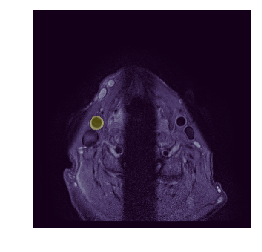

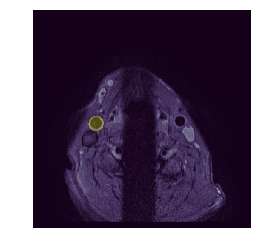

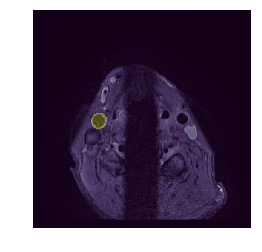

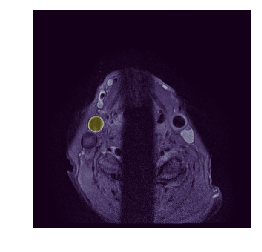

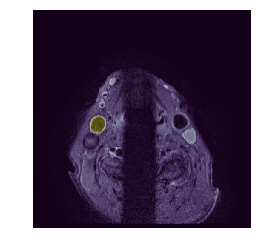

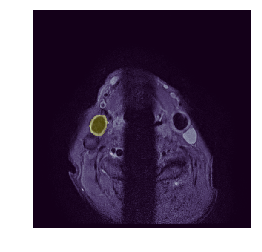

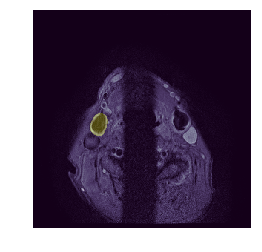

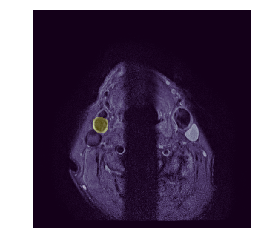

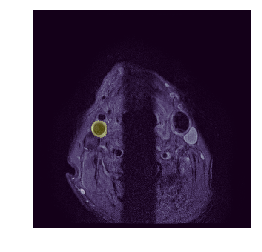

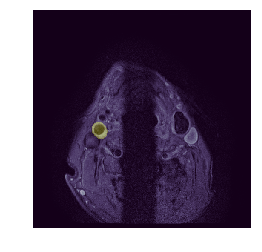

In [16]:
# visualization of the training patches

for i in range (0, 10):
    plt.imshow(X_train[i, ..., 0], cmap = 'bone')
    plt.imshow(y_train[i, ..., 0], alpha = 0.3)
    plt.axis('Off')
    plt.show()

## 2. Data augmentation

Defining transformations:

In [17]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomSizedCrop(min_max_height=(384, 512), height=512, width=512, p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(p=0.5),
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.5),
    A.RandomGamma(p=0.5)
])

Generation of the augmented patches:

In [18]:
# n_augms random transformations of the images X and masks y

def augment_ds(X, y, n_augms):
    
    counter = 0
    dim = y[0, ..., 0].shape
    n_samples = y.shape[0]
    
    X_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    y_aug = np.zeros((int(n_samples*n_augms), dim[0], dim[1], 1), dtype = np.uint8)
    
    for smpl in range (0, n_samples):
        for augm in range (0, n_augms):
            
            random.seed(counter)
            augmented = transform(image=X[smpl, ..., 0], mask=y[smpl, ..., 0])
            X_aug[counter, ..., 0] = augmented['image']
            y_aug[counter, ..., 0] = augmented['mask']
            counter += 1
            
    return X_aug, y_aug    

Writing augmented data into arrays:

In [19]:
X_train_aug, y_train_aug = augment_ds(X_train, y_train, 10)
X_valid_aug, y_valid_aug = augment_ds(X_train, y_train, 10)

Visualization of the transformed images:

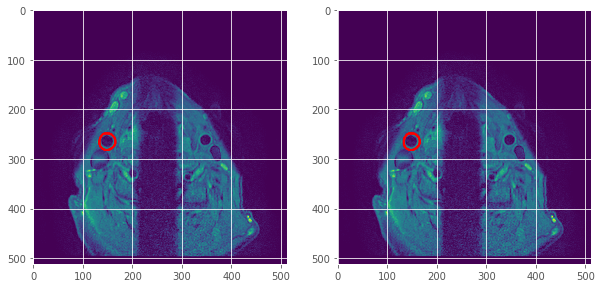

In [20]:
n_sample = 5

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X_train[n_sample//10, ..., 0])
plt.contour(y_train[n_sample//10, ..., 0], colors='r')
plt.subplot(122)
plt.imshow(X_train_aug[n_sample, ..., 0])
plt.contour(y_train_aug[n_sample, ..., 0], colors='r')
plt.show()

## 3. U-Net construction

Defining blocks:

In [21]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def get_unet(input_img, n_filters = 8, dropout = 0.2, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

Custom scores:

In [22]:
def dice_coef(y_true, y_pred):
    from keras import backend as K
    smooth=1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def custom_loss(y_true, y_pred):
    from keras.losses import binary_crossentropy
    return 0.5*keras.losses.binary_crossentropy(y_true,y_pred)+0.5*dice_loss(y_true,y_pred)

Model compilation:

In [23]:
input_img = Input((im_side, im_side, 1), name='img')

model_simple = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_simple.compile(optimizer=Adam(), loss=custom_loss, metrics=['accuracy', dice_coef])
model_simple.summary()

model_aug = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model_aug.compile(optimizer=Adam(), loss=custom_loss, metrics=['accuracy', dice_coef])
model_aug.summary()

W0623 13:36:35.873030 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0623 13:36:35.873030 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0623 13:36:35.879348 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0623 13:36:35.905344 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0623 13:36:35.9

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 512, 512, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 512, 512, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 512, 512, 16) 0           batch_normalization_20[0][0]     
__________________________________________________________________________________________________
max_poolin

Callbacks:

In [24]:
callbacks_simple = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/u-net_simple.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

callbacks_aug = [
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('../res/u-net_aug.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

## 4. Model training with and without augmentation

Models training (with and w/o augmentation):

In [25]:
# simple model (w/o data augmentation)

results_simple = model_simple.fit(X_train, y_train,
                                  batch_size=16, epochsint()=100, 
                                  callbacks=callbacks_simple, 
                                  validation_data=(X_valid, y_valid))

W0623 13:36:41.820575 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0623 13:36:42.386762 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0623 13:36:43.076260 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



Train on 1589 samples, validate on 345 samples
Epoch 1/100


W0623 13:36:45.240875 11408 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_2/convolution}}]]
	 [[metrics/acc/Mean_1/_1109]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_2/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [26]:
# data augmentation

results_aug = model_aug.fit(X_train_aug, y_train_aug,
                            batch_size=32, epochs=100, 
                            callbacks=callbacks_aug, 
                            validation_data=(X_valid_aug, y_valid_aug))

Train on 15890 samples, validate on 15890 samples
Epoch 1/100
15890/15890 [==============================] - 32s 2ms/step - loss: 0.2594 - acc: 0.9080 - dice_coef: 0.7246 - val_loss: 0.2111 - val_acc: 0.9318 - val_dice_coef: 0.7648

Epoch 00001: val_loss improved from inf to 0.21112, saving model to ../res/plaq-u-net_aug.h5
Epoch 2/100
15890/15890 [==============================] - 27s 2ms/step - loss: 0.1666 - acc: 0.9386 - dice_coef: 0.8303 - val_loss: 0.1620 - val_acc: 0.9470 - val_dice_coef: 0.8215

Epoch 00002: val_loss improved from 0.21112 to 0.16199, saving model to ../res/plaq-u-net_aug.h5
Epoch 3/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.1455 - acc: 0.9464 - dice_coef: 0.8533 - val_loss: 0.1501 - val_acc: 0.9520 - val_dice_coef: 0.8367

Epoch 00003: val_loss improved from 0.16199 to 0.15008, saving model to ../res/plaq-u-net_aug.h5
Epoch 4/100
15890/15890 [==============================] - 25s 2ms/step - loss: 0.1323 - acc: 0.9511 - dice_coef: 


Epoch 00031: val_loss did not improve from 0.05361
Epoch 32/100
15890/15890 [==============================] - 25s 2ms/step - loss: 0.0493 - acc: 0.9811 - dice_coef: 0.9494 - val_loss: 0.0545 - val_acc: 0.9827 - val_dice_coef: 0.9329

Epoch 00032: val_loss did not improve from 0.05361
Epoch 33/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0473 - acc: 0.9818 - dice_coef: 0.9514 - val_loss: 0.0502 - val_acc: 0.9837 - val_dice_coef: 0.9394

Epoch 00033: val_loss improved from 0.05361 to 0.05025, saving model to ../res/plaq-u-net_aug.h5
Epoch 34/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0470 - acc: 0.9820 - dice_coef: 0.9519 - val_loss: 0.0484 - val_acc: 0.9842 - val_dice_coef: 0.9421

Epoch 00034: val_loss improved from 0.05025 to 0.04842, saving model to ../res/plaq-u-net_aug.h5
Epoch 35/100
15890/15890 [==============================] - 25s 2ms/step - loss: 0.0459 - acc: 0.9824 - dice_coef: 0.9528 - val_loss: 0.0488 - val_acc:


Epoch 00062: val_loss did not improve from 0.03138
Epoch 63/100
15890/15890 [==============================] - 26s 2ms/step - loss: 0.0311 - acc: 0.9880 - dice_coef: 0.9678 - val_loss: 0.0316 - val_acc: 0.9909 - val_dice_coef: 0.9589

Epoch 00063: val_loss did not improve from 0.03138
Epoch 64/100
15890/15890 [==============================] - 25s 2ms/step - loss: 0.0312 - acc: 0.9880 - dice_coef: 0.9677 - val_loss: 0.0314 - val_acc: 0.9909 - val_dice_coef: 0.9591c: 0.9 - ETA: 2s - loss: 0.0313 - acc: 0.98 - ETA: 0s - loss: 0.0312 - acc: 0.9880 - dice_coef: 

Epoch 00064: val_loss did not improve from 0.03138
Epoch 65/100
15890/15890 [==============================] - 24s 2ms/step - loss: 0.0310 - acc: 0.9881 - dice_coef: 0.9679 - val_loss: 0.0313 - val_acc: 0.9909 - val_dice_coef: 0.9593

Epoch 00065: val_loss improved from 0.03138 to 0.03131, saving model to ../res/plaq-u-net_aug.h5
Epoch 66/100
15890/15890 [==============================] - 25s 2ms/step - loss: 0.0311 - acc: 0.9880

Learning curves visualization:

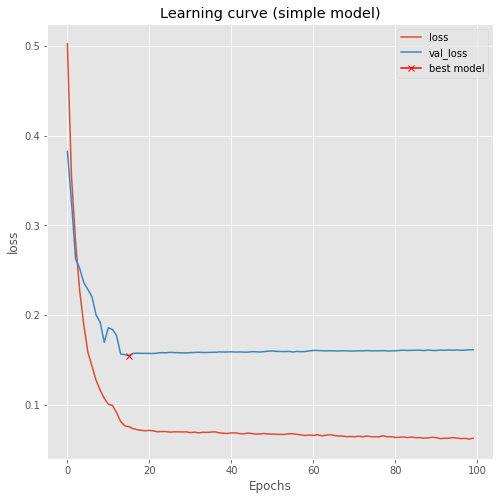

In [27]:
# simple model

plt.figure(figsize=(8, 8))
plt.title("Learning curve (simple model)")
plt.plot(results_simple.history["loss"], label="loss")
plt.plot(results_simple.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_simple.history["val_loss"]), np.min(results_simple.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

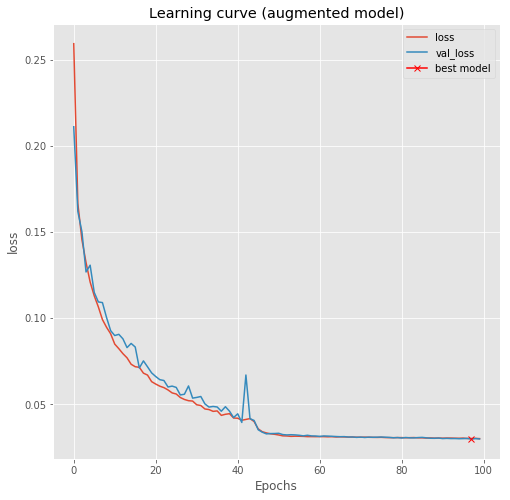

In [28]:
# augmented model

plt.figure(figsize=(8, 8))
plt.title("Learning curve (augmented model)")
plt.plot(results_aug.history["loss"], label="loss")
plt.plot(results_aug.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results_aug.history["val_loss"]), np.min(results_aug.history["val_loss"]), 
         marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

## 5. Models performance on patches

Loading weights:

In [18]:
model_simple.load_weights('../res/plaq-u-net_simple.h5')
model_aug.load_weights('../res/plaq-u-net_aug.h5')

W0419 14:49:34.450670 16840 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0419 14:49:35.927371 16840 module_wrapper.py:139] From C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\keras\backend\tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



Evaluating on the PATCHES of the validation set:

In [30]:
# simple model

model_simple.evaluate(X_valid, y_valid, verbose=1)

345/345 [==============================] - 0s 389us/step


[0.1549399169890777, 0.9473554965378581, 0.8519256545149761]

In [31]:
# augmented model:

model_aug.evaluate(X_valid, y_valid, verbose=1)

345/345 [==============================] - 0s 344us/step


[0.20700611333916152, 0.9471566461134648, 0.874064456552699]

Evaluation on the PATCHES of the test set:

In [32]:
# simple model

model_simple.evaluate(X_test, y_test, verbose=1)

360/360 [==============================] - 1s 2ms/step


[0.1456764154964023, 0.95582275390625, 0.8441155986239512]

In [33]:
# augmented model

model_aug.evaluate(X_test, y_test, verbose=1)

360/360 [==============================] - 0s 400us/step


[0.18678540885448455, 0.9543599446614583, 0.8773502283626132]

Predictions for the test set (+ thresholding):

In [19]:
preds_test_simple = model_simple.predict(X_test, verbose=1)
preds_test_simple_t = (preds_test_simple > 0.5).astype(np.uint8)

preds_test_aug = model_aug.predict(X_test, verbose=1)
preds_test_aug_t = (preds_test_aug > 0.5).astype(np.uint8)

360/360 [==============================] - 1s 2ms/step


Visualization of the prediction:

In [52]:
from matplotlib.patches import Patch
import matplotlib.font_manager as font_manager

In [63]:
font = font_manager.FontProperties(family='Times New Roman', weight='ultralight', size='12')

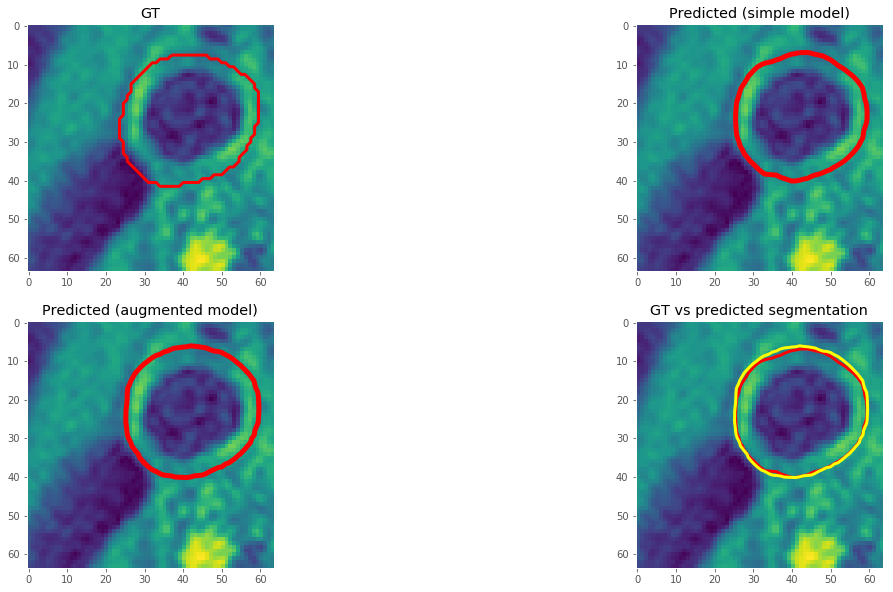

In [69]:
ix = 90

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

ax[0,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,0].contour(y_test[ix].squeeze(), colors='r', levels=[0.5], linewidths=3)
ax[0,0].set_title('GT')
ax[0,0].grid(False)

ax[0,1].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[0,1].contour(preds_test_simple[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
ax[0,1].set_title('Predicted (simple model)')
ax[0,1].grid(False)

ax[1,0].imshow(X_test[ix, ..., 0], cmap='viridis')
ax[1,0].contour(preds_test_aug[ix].squeeze(), colors='r', levels=[0.5], linewidths=5)
ax[1,0].set_title('Predicted (augmented model)')
ax[1,0].grid(False)

ax[1,1].imshow(X_test[ix, ..., 0].squeeze())
ax[1,1].contour(preds_test_simple[ix].squeeze(), colors='red', levels=[0.5], linewidths=3)
ax[1,1].contour(preds_test_aug[ix].squeeze(), colors='yellow', levels=[0.5], linewidths=3)
ax[1,1].set_title('GT vs predicted segmentation')
#legend_elements = [Patch(facecolor='red', label='Groundtruth'),
#                   Patch(facecolor='yellow', label='Autosegmentation')]
#ax[1,1].legend(handles=legend_elements, loc=4, prop=font)
ax[1,1].grid(False)

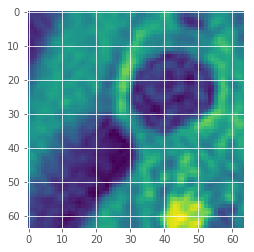

In [66]:
plt.imshow(X_test[ix, ..., 0], cmap='viridis')
#plt.imshow(y_test[ix].squeeze())
plt.show()

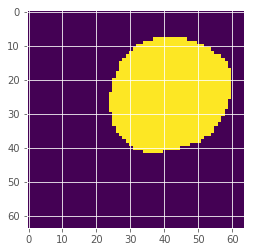

In [67]:
#plt.imshow(X_test[ix, ..., 0], cmap='viridis')
plt.imshow(y_test[ix].squeeze())
plt.show()

In [76]:
sub_names_emc

['EMC003',
 'EMC004',
 'EMC005',
 'EMC007',
 'EMC008',
 'EMC009',
 'EMC011',
 'EMC015',
 'EMC018',
 'EMC020',
 'EMC024',
 'EMC027',
 'EMC029',
 'EMC031',
 'EMC032',
 'EMC034',
 'EMC035',
 'EMC036',
 'EMC038',
 'EMC041',
 'EMC042',
 'EMC043',
 'EMC045',
 'EMC046',
 'EMC047',
 'EMC048',
 'EMC049',
 'EMC050',
 'EMC051',
 'EMC052',
 'EMC054',
 'EMC055',
 'EMC056',
 'EMC057']